In [101]:
import os
import json
import openai
import numpy as np

from llama_index.core.evaluation import ContextRelevancyEvaluator
from llama_index.llms.openai import OpenAI
from llama_index.core.prompts import PromptTemplate
from llama_index.llms.anthropic import Anthropic
from llama_index.core import Settings

from config import MAIN_DIR, DATA_DIR
from utils import count_tokens

In [21]:
import nest_asyncio
from tqdm.asyncio import tqdm_asyncio
nest_asyncio.apply()

import phoenix as px

# Look for a URL in the output to open the App in a browser.
px.launch_app()
# The App is initially empty, but as you proceed with the steps below,
# traces will appear automatically as your LlamaIndex application runs.

import llama_index.core

llama_index.core.set_global_handler("arize_phoenix")

/mnt/c/Users/QUAN/Desktop/llm_eval/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [171]:
with open(os.path.join(MAIN_DIR, "auth", "api_keys.json"), "r") as f:
    api_keys = json.load(f)

os.environ["OPENAI_API_KEY"] = api_keys["OPENAI_API_KEY"]
os.environ["ANTHROPIC_API_KEY"] = api_keys["ANTHROPIC_API_KEY"]

openai.api_key = api_keys["OPENAI_API_KEY"]

In [3]:
def displayify_df(df):
    """For pretty displaying DataFrame in a notebook."""
    display_df = df.style.set_properties(
        **{
            "inline-size": "300px",
            "overflow-wrap": "break-word",
        }
    )
    display(display_df)

In [191]:
eval_idx = [1,6,8,9,10,11,20,21,23,27,28,29,32,47,48,51,52,54,56,57]

In [196]:
relevancy_prompt_str = """You are a radiologist expert at providing imaging recommendations for patients with musculoskeletal conditions.
Your task is to evaluate if the retrieved context from the document sources are relevant to the patient profile in the context of ordering MRI scans.
The evaluation should be performed in a step-by-step manner by answering the following questions:
1. Does the retrieved context match the description of the patient inside the query?
2. Can the retrieved context be used exclusively to answer whether it is appropriate to order MRI scans for the particular patient?
3. How concise is the retrieved context, is there a lot of irrelevant information or repeated information?
Each question above is worth 5 points, where partial marks are allowed and encouraged. 
Provide detailed feedback on the response according to the criteria questions previously mentioned.
After your feedback provide a final result by strictly following this format: '[RESULT] followed by the float number representing the total score assigned to the response'.

Query: 
  {query_str}
Context:
  {context_str}
Feedback:
"""

RELEVANCY_EVAL_TEMPLATE = PromptTemplate(relevancy_prompt_str)

SCORE_THRESHOLD = 15

In [197]:
relevancy_judge = ContextRelevancyEvaluator(
    llm=OpenAI(temperature=0, model="gpt-4"),
    # llm = Anthropic(model="claude-3-opus-20240229"),
    eval_template=RELEVANCY_EVAL_TEMPLATE,
    score_threshold=SCORE_THRESHOLD
)

In [ ]:
# # Check for token limit
# for query, context in zip(eval_queries, eval_contexts):
#     full_str_prompt = RELEVANCY_EVAL_TEMPLATE.format(
#         query_str=query, context_str="\n".join(context)
#     )
#     print(count_tokens(full_str_prompt))

In [ ]:
score_dict = {}

search_params = {
    "top_k": [3, 5, 7],
    "chunk_size": [256, 512, 1024]
}

for chunk_size in search_params["chunk_size"]:
    for top_k in search_params["top_k"]:

        with open(
            os.path.join(DATA_DIR, "msk_mri", "retrieval_dataset_FreeText-Chunk_size=1024-K=7.json"),
            "r"
        ) as f:
            prediction_dataset = json.load(f)

        eval_queries = np.array(prediction_dataset["question"])[eval_idx]
        eval_contexts = np.array(prediction_dataset["contexts"])[eval_idx]
        
        eval_tasks  = []
        
        for query, context in zip(eval_queries, eval_contexts):
            eval_tasks.append(
                relevancy_judge.aevaluate(query=query, contexts=context.tolist())
            )
            
        eval_results = await tqdm_asyncio.gather(*eval_tasks)
        eval_scores = [eval_result.score for eval_result in eval_results]
        eval_feedbacks = [eval_result.feedback for eval_result in eval_results]
        
        score_dict[f"{chunk_size}_{top_k}"] = {
            "scores": eval_scores, "feedback": eval_feedbacks
        }
        
with open("./eval_results.json", "w") as f:
    json.dump(score_dict, f)

In [227]:
print(eval_feedbacks[0])

1. The retrieved context matches the description of the patient inside the query. The patient has known ankylosing spondylitis and is on infliximab treatment. The context discusses the use of MRI in evaluating treatment response or disease progression in patients with axial spondyloarthritis, which includes ankylosing spondylitis. The context also mentions the use of TNF-inhibitors, which includes infliximab. Therefore, the context is relevant to the patient's profile. (5/5)
2. The retrieved context can be used to answer whether it is appropriate to order MRI scans for the particular patient. The context mentions that there is no standard method of following patients with MRI to evaluate for treatment response or disease progression. However, it also states that MRI can be helpful in cases where the disease activity is unclear, clinical or laboratory data are conflicting, or knowledge of MRI findings is expected to alter treatment. Given that the patient has no breakthrough symptoms, t

In [211]:
for k, v in score_dict.items():
    print(k, np.mean(v["scores"]))

256_3 0.74
256_5 0.7266666666666667
256_7 0.7433333333333335
512_3 0.7233333333333334
512_5 0.7433333333333334
512_7 0.7466666666666668
1024_3 0.7500000000000001
1024_5 0.7633333333333334
1024_7 0.7299999999999999


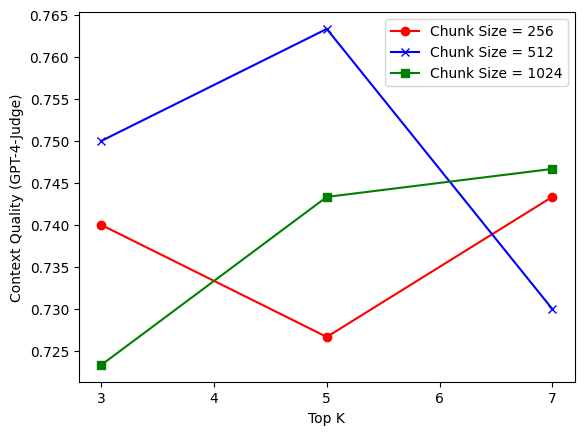

In [225]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    [3, 5, 7], [0.74, 0.7266666666666667, 0.7433333333333335],
    label="Chunk Size = 256", color = "red", marker = "o"
)

plt.plot(
    [3, 5, 7], [0.7500000000000001, 0.7633333333333334, 0.7299999999999999],
    label="Chunk Size = 512", color = "blue", marker = "x"
)

plt.plot(
    [3, 5, 7], [0.7233333333333334, 0.7433333333333334, 0.7466666666666668],
    label="Chunk Size = 1024", color = "green", marker = "s"
)

plt.ylabel("Context Quality (GPT-4-Judge)")
plt.xlabel("Top K")
plt.xticks([3,4,5,6,7])
plt.legend()

 90%|█████████ | 18/20 [5:52:43<39:11, 1175.75s/it]


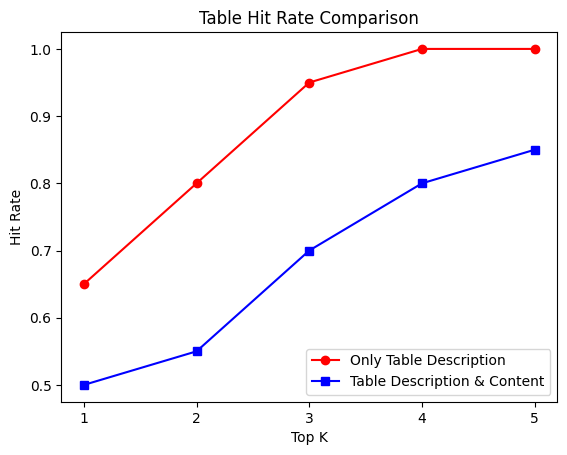

In [223]:
plt.figure()
plt.plot(
    [1, 2, 3, 4, 5],
    [0.65, 0.8, 0.95, 1, 1], 
    label="Only Table Description", color = "red", marker = "o",
)

plt.plot(
    [1, 2, 3, 4, 5],
    [0.5, 0.55, 0.7, 0.8, 0.85], 
    label="Table Description & Content", color = "blue", marker = "s",
)

plt.title("Table Hit Rate Comparison")
plt.ylabel("Hit Rate")
plt.xlabel("Top K")
plt.xticks([1,2,3,4,5])
plt.legend()